In [1]:
pip install lightgbm xgboost catboost optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 3.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [26]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from scipy.stats import rankdata
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna as op

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-3/train.csv'
file_key_2 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-3/test.csv'
file_key_3 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-3/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)
submission = pd.read_csv(file_content_stream_3)

## Replacing weird Education value
train.loc[train['Education'] == 15, 'Education'] = 5

## Dropping features 
train = train.drop(columns = ['EmployeeCount', 'Over18', 'StandardHours'], axis = 1)
test = test.drop(columns = ['EmployeeCount', 'Over18', 'StandardHours'], axis = 1)

# Random Forest Modeling

In [12]:
train_RF = train.copy()
test_RF = test.copy()

## Defining inputs and target
train_dummies = pd.get_dummies(train_RF[['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']])
train_dummies = train_dummies.drop(columns = ['BusinessTravel_Non-Travel', 'Department_Research & Development', 'EducationField_Other', 'Gender_Female', 'JobRole_Manufacturing Director', 'MaritalStatus_Divorced', 'OverTime_No'])

X = train_RF.drop(columns = ['id', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 'Attrition'], axis = 1)
X = pd.concat([X, train_dummies], axis = 1)
Y = train_RF['Attrition']

X['feature_1'] = np.where(((X['StockOptionLevel'] >= 1) & (X['YearsAtCompany'] >= 3) & (X['YearsWithCurrManager'] >= 1)), 1, 0)
X['feature_2'] = np.where(((X['StockOptionLevel'] < 1) & (X['MonthlyIncome'] > 2700) & (X['OverTime_Yes'] < 1)), 1, 0) 

test_dummies = pd.get_dummies(test_RF[['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']])
test_dummies = test_dummies.drop(columns = ['BusinessTravel_Non-Travel', 'Department_Research & Development', 'EducationField_Other', 'Gender_Female', 'JobRole_Manufacturing Director', 'MaritalStatus_Divorced', 'OverTime_No'])

test_RF = test_RF.drop(columns = ['id', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime'], axis = 1)
test_RF = pd.concat([test_RF, test_dummies], axis = 1)

test_RF['feature_1'] = np.where(((test_RF['StockOptionLevel'] >= 1) & (test_RF['YearsAtCompany'] >= 3) & (test_RF['YearsWithCurrManager'] >= 1)), 1, 0)
test_RF['feature_2'] = np.where(((test_RF['StockOptionLevel'] < 1) & (test_RF['MonthlyIncome'] > 2700) & (test_RF['OverTime_Yes'] < 1)), 1, 0) 

cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = 42)

logit_md = 

RF_md = RandomForestClassifier(max_depth = 7, min_samples_leaf = 5, min_samples_split = 2, n_estimators = 500)

XGB_md = XGBClassifier(colsample_bytree = 0.7, 
                               gamma = 0.8, 
                               learning_rate = 0.01, 
                               max_depth = 7, 
                               min_child_weight = 10, 
                               n_estimators = 500, 
                               subsample = 0.7)

lgb_md = LGBMClassifier(n_estimators = 1000,
                        max_depth = 7,
                        learning_rate = 0.01,
                        num_leaves = 10,
                        lambda_l1 = 3,
                        lambda_l2 = 3,
                        bagging_fraction = 0.7,
                        feature_fraction = 0.7)

cat_md = CatBoostClassifier(iterations = 1000, 
                            depth = 7,
                            learning_rate = 0.01,
                            rsm = 0.5,
                            subsample = 0.9,
                            l2_leaf_reg = 69,
                            min_data_in_leaf = 20,
                            random_strength = 0.175,
                            random_seed = 836,
                            task_type = 'CPU',
                            bootstrap_type = 'Bernoulli',
                            grow_policy = 'SymmetricTree',
                            loss_function = 'Logloss',
                            verbose = False)

RF_scores = cross_val_score(RF_md, X, Y, scoring = 'roc_auc' , cv = cv, n_jobs = -1)
XGB_scores = cross_val_score(XGB_md, X, Y, scoring = 'roc_auc' , cv = cv, n_jobs = -1)
lgb_scores = cross_val_score(lgb_md, X, Y, scoring = 'roc_auc' , cv = cv, n_jobs = -1)
cat_scores = cross_val_score(cat_md, X, Y, scoring = 'roc_auc' , cv = cv, n_jobs = -1)

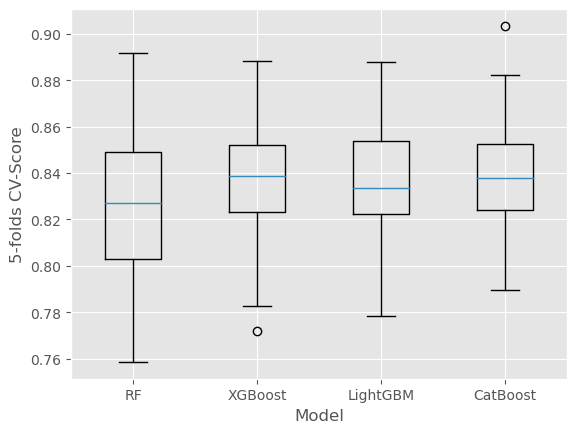

In [25]:
import matplotlib.pyplot as plt; plt.style.use('ggplot')

md_scores = pd.DataFrame({'RF': RF_scores, 'XGB': XGB_scores, 'LightGBM': lgb_scores, 'CatBoost': cat_scores})
plt.boxplot(md_scores, labels = ['RF', 'XGBoost', 'LightGBM', 'CatBoost'])
plt.xlabel('Model')
plt.ylabel('5-folds CV-Score');
# sns.boxplot(md_scores);